In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
from keras.models import load_model
import itertools 
filterwarnings('ignore')
np.random.seed(101)
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Mon Sep 12 07:30:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
train_dir ="/content/drive/MyDrive/HE/train"
val_dir="/content/drive/MyDrive/HE/test"
test_dir="/content/drive/MyDrive/HE/test"
labels = ['0', '1', '2', '3']
label_np=np.array(labels)

In [5]:
import tensorflow as tf
import numpy as np
import os
import random


def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


seed = 101
set_seed(seed)

In [6]:
model1 = InceptionResNetV2(include_top=False,input_shape=(299, 299,3), weights='imagenet')
input_shape = (299, 299)

219070464/219055592 [==============================] - 7s 0us/step


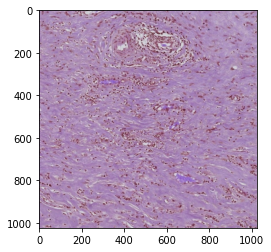

In [7]:
im1 = cv2.imread("/content/drive/MyDrive/HE/train/0/0.15.jpg")
plt.imshow(im1)

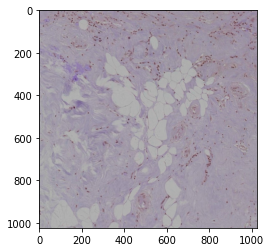

In [8]:
im2 = cv2.imread("/content/drive/MyDrive/HE/train/1/1.4.jpg")
plt.imshow(im2)

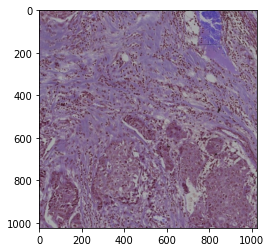

In [9]:
im3 = cv2.imread("/content/drive/MyDrive/HE/train/2/2.69.jpg")
plt.imshow(im3)

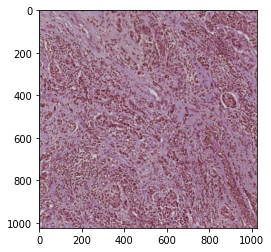

In [10]:
im4 = cv2.imread("/content/drive/MyDrive/HE/train/3/3.152.jpg")
plt.imshow(im4)

In [11]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=2,
                                  vertical_flip=True,
                                  horizontal_flip=False)

datagen_test = ImageDataGenerator(rescale=1./255)

datagen_val=ImageDataGenerator(rescale=1./255)

batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,                                        
                                                    shuffle=True)

generator_val = datagen_val.flow_from_directory(directory=val_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)
generator_test=datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                 batch_size=batch_size,
                                                 shuffle=False)

Found 3896 images belonging to 4 classes.
Found 977 images belonging to 4 classes.
Found 977 images belonging to 4 classes.


In [12]:
headModel = model1.output
headModel = layers.GlobalAveragePooling2D()(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = layers.BatchNormalization()(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(512, activation="relu", dtype='float32')(headModel)
headModel = layers.BatchNormalization()(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(4, activation="softmax")(headModel)
model = Model(inputs=model1.input, outputs=headModel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['accuracy','Precision','Recall', 'AUC']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [14]:

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

earlystopping = EarlyStopping(monitor ="val_loss", 
                              mode ="min", patience = 3, 
                              restore_best_weights = True)
history = model.fit_generator(generator=generator_train,
                              epochs=80,
                              validation_data=generator_val,
                              validation_steps=steps_test,
                              callbacks =[earlystopping]
                              )


Epoch 1/80
244/244 [==============================] - 3431s 14s/step - loss: 1.9087 - accuracy: 0.2662 - precision: 0.2716 - recall: 0.1689 - auc: 0.5087 - val_loss: 1.3789 - val_accuracy: 0.3204 - val_precision: 0.4286 - val_recall: 0.0154 - val_auc: 0.5712
Epoch 2/80
244/244 [==============================] - 212s 869ms/step - loss: 1.8067 - accuracy: 0.2798 - precision: 0.2892 - recall: 0.1804 - auc: 0.5376 - val_loss: 1.2984 - val_accuracy: 0.4074 - val_precision: 0.5130 - val_recall: 0.1208 - val_auc: 0.6624
Epoch 3/80
244/244 [==============================] - 208s 850ms/step - loss: 1.6698 - accuracy: 0.3247 - precision: 0.3372 - recall: 0.2105 - auc: 0.5781 - val_loss: 1.2676 - val_accuracy: 0.4473 - val_precision: 0.5204 - val_recall: 0.1955 - val_auc: 0.6885
Epoch 4/80
244/244 [==============================] - 210s 859ms/step - loss: 1.6131 - accuracy: 0.3427 - precision: 0.3661 - recall: 0.2292 - auc: 0.6007 - val_loss: 1.2097 - val_accuracy: 0.4739 - val_precision: 0.5478 

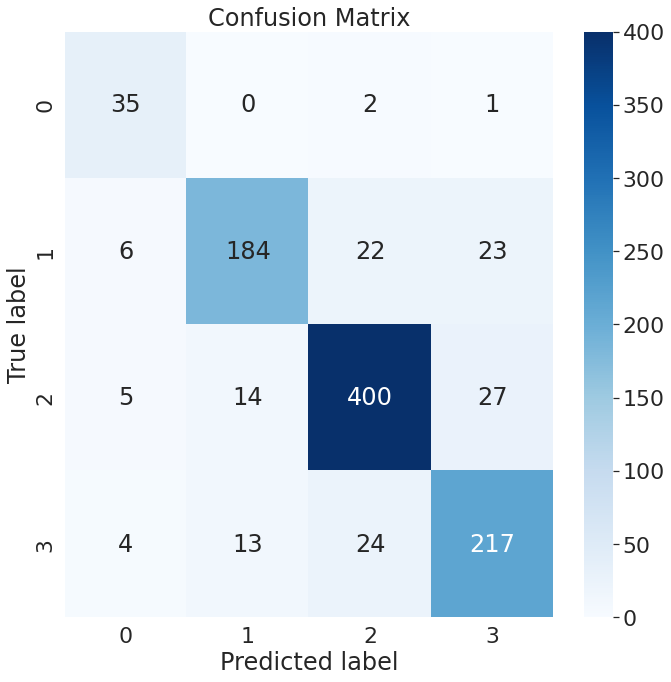

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(generator_test)
y_pred = np.argmax(Y_pred, axis=1)
array = confusion_matrix(generator_test.classes, y_pred)
df_cm = pd.DataFrame(array, index =['0', '1', '2', '3'],
                  columns = ['0', '1', '2', '3'])
plt.figure(figsize=(10,10))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('model1_confusion',dpi=200); 
plt.show()

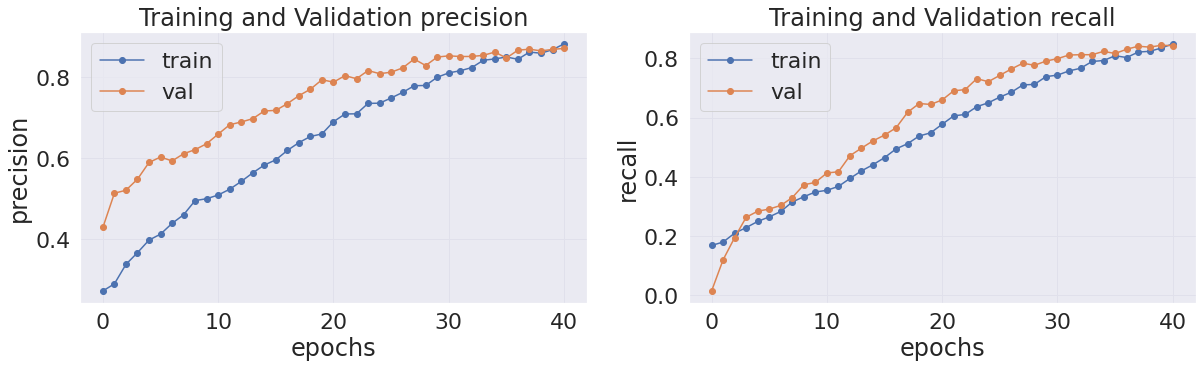

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met],'o-')
    ax[i].plot(history.history['val_' + met],'o-')
    ax[i].set_title('Training and Validation {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(color = '#e0e0eb')
    ax[i].legend(['train', 'val'])

fig.savefig('model1_precision_recall',dpi=1200); 

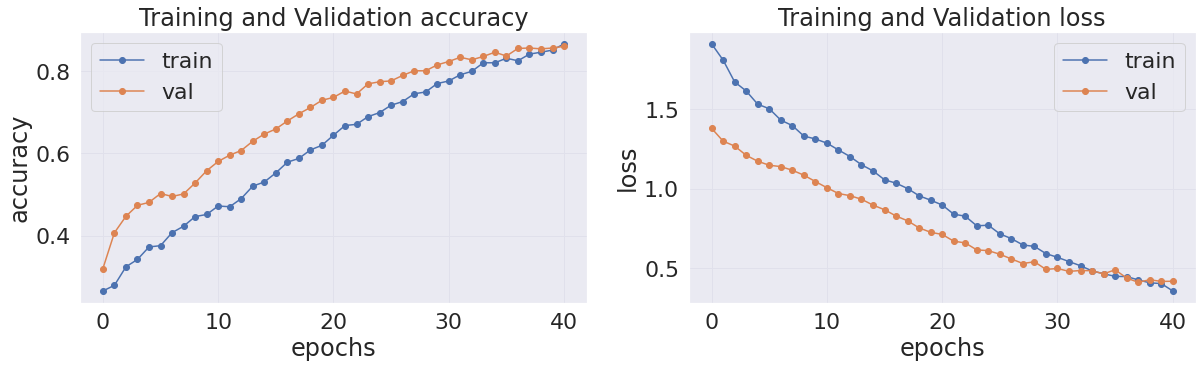

In [17]:

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()
for i, met in enumerate([ 'accuracy', 'loss']):
    ax[i].plot(history.history[met] , 'o-')
    ax[i].plot(history.history['val_' + met], 'o-')
    ax[i].set_title('Training and Validation {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(color = '#e0e0eb')
    ax[i].legend(['train', 'val'],loc='best')

fig.savefig('model1_accuracy_loss',dpi=1200); 

plt.show()

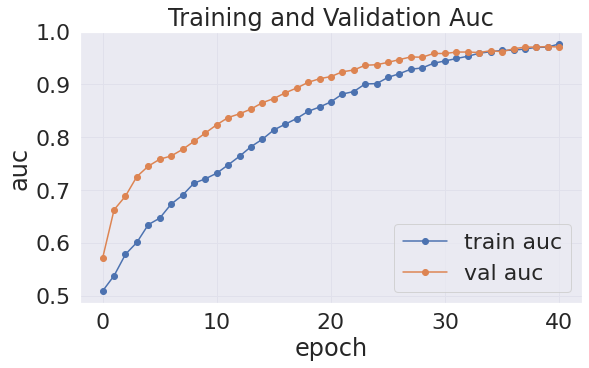

In [18]:

plt.figure(figsize=(9, 5))
ax = plt.axes()
ax.set_facecolor("#eaeaf2")
plt.plot(history.history['auc'],'o-',label="train auc")
plt.plot(history.history['val_auc'],'o-',label="val auc")
plt.title('Training and Validation Auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend()
plt.grid(color = '#e0e0eb')
plt.savefig('model1_accuracy',dpi=1200); 
plt.show()
